# IconQA Fill-In-The-Blank with GPT-4o and Tool Use (aka Structured Generation)

NOTE: NOT ELIGIBLE FOR USE IN THE CHALLENGE

In [31]:
# !pip install -q openai

In [14]:
import os
import json

import pandas as pd
from PIL import Image

In [3]:
from openai import OpenAI
client = OpenAI(api_key="sk-<secret>")

In [5]:
from notebooks_shared_utils import load_image_and_convert_to_base64

In [8]:
def build_tool():
    return {
        "type": "function",
        "function": {
            "name": "iconqa_qna_tool",
            "description": "IconQA Fill-in-the-blank Tool",
            "parameters": {
                "type": "object",
                "properties": {
                    "reasoning": {"type": "string"},
                    "answer": {
                        "type": "string",
                        "description": "Exact answer to the user question."
                    },
                },
                "required": ["reasoning", "answer"],
            },
        }
    }

In [9]:
SYSTEM_PROMPT = "You are a question-and-answer tool. You get an image as an input and you must answer the user's question from the data you extract from the image. Output in json format."

In [17]:
def run_inference(image_path, question, model="gpt-4o-2024-05-13", seed=0):
    image_base64 = load_image_and_convert_to_base64(image_path)
    question_trimmed = question[len("<image>\n"):]
    print(f"{question_trimmed = }")
    tool = build_tool()
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": SYSTEM_PROMPT,
                    }
                ]
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_base64}"},
                    },
                    {
                        "type": "text",
                        "text": question_trimmed,
                    }
                ]
            },
        ],
        temperature = 1,
        # max_tokens=256,
        seed=seed,
        top_p = 1,
        frequency_penalty = 0,
        presence_penalty = 0,
        tools = [tool],
        tool_choice = {
            "type": "function",
            "function": {"name": tool["function"]["name"]},
        },
    )
    response_args = response.choices[0].message.tool_calls[0].function.arguments
    print(f"{response_args = }")
    return json.loads(response_args)["answer"]

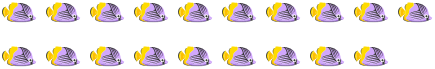

In [18]:
image_path = "data/raw_datasets/iconqa/iconqa_data/iconqa/val/fill_in_blank/20847/image.png"
image = Image.open(image_path)
image

In [19]:
question = """<image>\nRepresent the icon. Question "How many fish are there?" Fill in the empty spaces:"""
run_inference(image_path, question)

question_trimmed = 'Represent the icon. Question "How many fish are there?" Fill in the empty spaces:'
response_args = '{"reasoning":"The image depicts 18 fish icons arranged in a sequence.","answer":"18"}'


'18'

In [20]:
dataset_name = "iconqa_fill_in_blank"
dataset_path = os.path.join("data/processed_data", dataset_name, "converted_output_test.json")
print(dataset_path)
assert os.path.exists(dataset_path)

df_data = pd.read_json(dataset_path)

data/processed_data/iconqa_fill_in_blank/converted_output_test.json


In [21]:
!mkdir -p inference_results/gpt-4o

In [29]:
failed_idx = set()
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/gpt-4o/{dataset_name}_{id}.txt"
    if os.path.exists(answer_txt_path):
        continue

    image_path = row['image']
    question = row["conversations"][0]["value"]
    print(id, idx, image_path)

    try:
        answer = run_inference(image_path, question)
        with open(answer_txt_path, "w") as f:
            f.write(answer)
    except Exception as e:
        print(idx, row, e)
        failed_idx.add(idx)

In [30]:
failed_idx = set(failed_idx)
failed_idx

set()